We want to explore a first solution guided by common rules of thumb when building CNNs.

# 1 - Load data


In [11]:
import models.structure.base_model_wrapper
from dataset.k_fold_dataset_wrapper import KFoldDatasetWrapper
from torch.utils.data import DataLoader
from dataset.dataset_loader import dataset_loader

train, test = dataset_loader((224, 224), is_grayscale=False)

# We take 20% of train as validation.
dataset_split_controller = KFoldDatasetWrapper(5)
dataset_split_controller.load_data(train)

local_train, validation = dataset_split_controller.get_data_for_fold(0)

train_dataloader = DataLoader(dataset=local_train, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(dataset=validation, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test, batch_size=32, shuffle=True)

In [2]:
print(f"Validation set is {len(validation) / (len(train) + len(test)) * 100:.2f}% of total dataset.")
print(f"This might be too little to realistically do some early stopping. Estimating epoches might be the way to go.")

Validation set is 16.00% of total dataset.
This might be too little to realistically do some early stopping. Estimating epoches might be the way to go.


# 2 - Handmade First Attempt
The first handmade attempt is done before fine tuning the hyperparameters. We simply follow,
for this step, common rules of thumb such as:
- The number of filter may be mixed in increasing order to better match more complex patterns in the images
- A (3x3) kernel generally performs well
- CNN benefit from having a multiple succession of layers

## 2.1 - Model Definition

In [3]:
from keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense, Layer
from models.structure.base_model_wrapper import BaseModelWrapper


class HandTailoredConvNet(BaseModelWrapper):
    def make_layers(self, input_shape: (int, int, int)) -> tuple[Layer, Layer]:
        chan = self.data_format.value
        input_layer = Input(shape=input_shape, name=self.__class__.__name__)

        x = Conv2D(64, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(input_layer)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(x)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)

        x = Flatten()(x)
        x = Dense(units=128, activation="relu")(x)

        output_layer = Dense(units=1, activation="sigmoid")(x)
        return input_layer, output_layer

## 2.2 - Make Model Instance

In [4]:
from models.structure.learning_parameters.sgd_learning_parameters import SgdLearningParameters

model = HandTailoredConvNet().make_model((3, 224, 224))

learning_parameters = SgdLearningParameters(learning_rate=1e-3)
learning_parameters.compile_model(model)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HandTailoredConvNet             │ (None, 3, 224, 224)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 224, 224)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 112, 112)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 56, 56)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,456,129 (196.29 MB)

 Trainable params: 51,456,129 (196.29 MB)

 Non-trainable params: 0 (0.00 B)

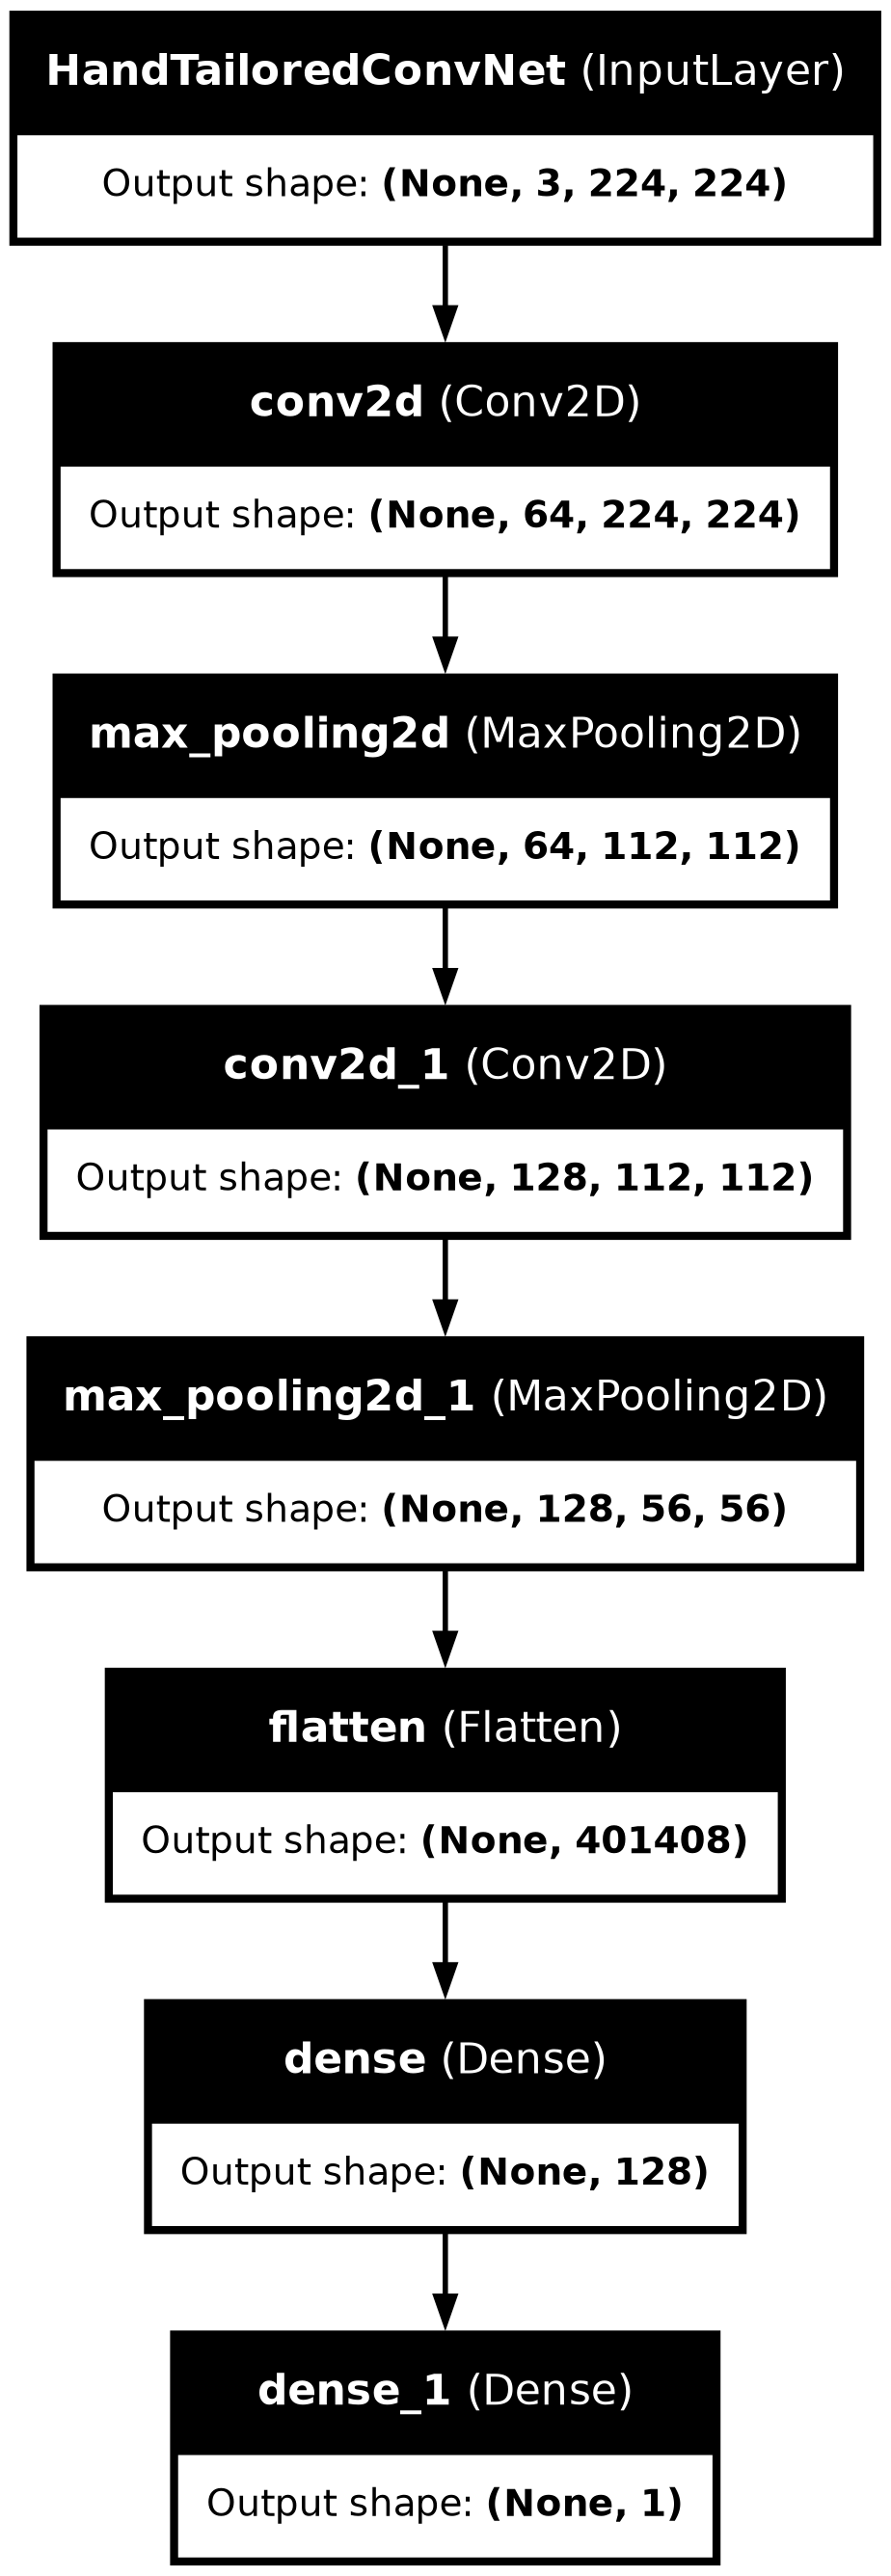

In [5]:
import keras

keras.utils.plot_model(
    model, to_file='hand_tailored_conv_net.png', show_layer_names=True, expand_nested=True, show_shapes=True
)

## 2.3 - Learning

In [6]:
import keras

# In this simple approach we have fixed [Train 0.8 - Val 0.2 - Test] without doing any k-fold CV.
# The number of epoches is fixed by early stopping. (In the case of k-fold-CV it will be a hp given by average performance?)
history = model.fit(x=train_dataloader, validation_data=validation_dataloader, batch_size=32, epochs=40, callbacks=[
    # To avoid going further when training
    keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=5,
        verbose=1, mode='min', restore_best_weights=True
    ),
    # To persist the history
    keras.callbacks.CSVLogger(f"hand-tailored-cnn.log", separator=",", append=True)
])

Epoch 1/40
  1/119 ━━━━━━━━━━━━━━━━━━━━ 49s 422ms/step - accuracy: 0.5938 - loss: 0.6907

/home/jacopo/miniconda3/envs/keras-pytorch/lib/python3.12/site-packages/keras/src/backend/torch/nn.py:412: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987296916/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  outputs = tnn.conv2d(


119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 416ms/step - accuracy: 0.5740 - loss: 0.6685 - val_accuracy: 0.6948 - val_loss: 0.5546
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 427ms/step - accuracy: 0.7524 - loss: 0.5288 - val_accuracy: 0.7941 - val_loss: 0.4574
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step - accuracy: 0.7951 - loss: 0.4641 - val_accuracy: 0.5882 - val_loss: 0.8047
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 404ms/step - accuracy: 0.8104 - loss: 0.4137 - val_accuracy: 0.8120 - val_loss: 0.4236
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 412ms/step - accuracy: 0.8383 - loss: 0.3735 - val_accuracy: 0.8300 - val_loss: 0.3760
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.8639 - loss: 0.3428 - val_accuracy: 0.8427 - val_loss: 0.3570
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 414ms/step - accuracy: 0.8616 - loss: 0.3416 - val_accuracy: 0.8458 - val_loss: 0.3599
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 415ms/step - accuracy: 0.8847 - loss: 0.2854 - val

## 2.4 - Results

In [7]:
res = model.evaluate(test_dataloader)
persist_model: bool = True

# We don't want to persist the model as I already saved it.
if persist_model:
    model.save('hand_tailored_conv_net.keras')

print(f"Test accuracy is {res[1] * 100:.2f}% while loss is {res[0]}")
print(f"The model is not that bad considering we have no pre-processing done and the parameters were chosen freely")

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.8663 - loss: 0.3466


2024-05-14 17:23:58.557818: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 17:23:58.579376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 17:23:59.198747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Test accuracy is 86.82% while loss is 0.3447136878967285
The model is not that bad considering we have no pre-processing done and the parameters were chosen freely


In [10]:
from utils.data_processing import make_loss_graphs, make_loss_accuracy_graphs, add_tuner_iteration_to_data
import pandas

csv = pandas.read_csv(f"hand-tailored-cnn.log")
add_tuner_iteration_to_data(csv)

loss_graph = make_loss_graphs(csv)
acc_graph = make_loss_accuracy_graphs(csv)

loss_graph.update_layout(title="Loss vs Val_loss in tuner search per epoch (Val dashed)").show()
acc_graph.update_layout(title="Accuracy vs Val_Accuracy in tuner search per epoch (Val dashed)").show()

# 3 - Enhance previous model

## 3.1 - Model definition

In [11]:
from keras.layers import Dropout
class HandTailoredConvNet(BaseModelWrapper):
    def make_layers(self, input_shape: (int, int, int)) -> tuple[Layer, Layer]:
        chan = self.data_format.value
        input_layer = Input(shape=input_shape, name=self.__class__.__name__)

        x = Conv2D(64, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(input_layer)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)
        x = Dropout(rate=0.2)(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(x)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)
        x = Dropout(rate=0.2)(x)

        x = Flatten()(x)
        x = Dense(units=128, activation="relu")(x)

        output_layer = Dense(units=1, activation="sigmoid")(x)
        return input_layer, output_layer

## 3.2 - Make model instance

In [12]:
from models.structure.learning_parameters.sgd_learning_parameters import SgdLearningParameters

model = HandTailoredConvNet().make_model((3, 224, 224))
learning_parameters.compile_model(model)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HandTailoredConvNet             │ (None, 3, 224, 224)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 224, 224)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 112, 112)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 56, 56)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 56, 56)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,456,129 (196.29 MB)

 Trainable params: 51,456,129 (196.29 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 - Learning

In [13]:
import keras

# In this simple approach we have fixed [Train 0.8 - Val 0.2 - Test] without doing any k-fold CV.
# The number of epoches is fixed by early stopping. (In the case of k-fold-CV it will be a hp given by average performance?)
history = model.fit(x=train_dataloader, validation_data=validation_dataloader, batch_size=32, epochs=40, callbacks=[
    # To avoid going further when training
    keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=5,
        verbose=1, mode='min', restore_best_weights=True
    ),
    # To persist the history
    keras.callbacks.CSVLogger(f"hand-tailored-cnn-dropout.log", separator=",", append=True)
])

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 417ms/step - accuracy: 0.5434 - loss: 0.7010 - val_accuracy: 0.6969 - val_loss: 0.6487
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.6475 - loss: 0.6353 - val_accuracy: 0.6367 - val_loss: 0.6049
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 428ms/step - accuracy: 0.7193 - loss: 0.5450 - val_accuracy: 0.7666 - val_loss: 0.5050
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 428ms/step - accuracy: 0.7557 - loss: 0.4998 - val_accuracy: 0.7677 - val_loss: 0.4648
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 416ms/step - accuracy: 0.8017 - loss: 0.4440 - val_accuracy: 0.7561 - val_loss: 0.4757
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 405ms/step - accuracy: 0.8210 - loss: 0.4156 - val_accuracy: 0.6874 - val_loss: 0.7121
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 414ms/step - accuracy: 0.8159 - loss: 0.4088 - val_accuracy: 0.7983 - val_loss: 0.4601
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 412ms/step - accuracy: 0.8387 - loss: 0

## 3.4 - Results

In [14]:
res = model.evaluate(test_dataloader)
persist_model: bool = True

# We don't want to persist the model as I already saved it.
if persist_model:
    model.save('hand_tailored_conv_net_dropout.keras')

print(f"Test accuracy is {res[1] * 100:.2f}% while loss is {res[0]}")
print(f"The model is not that bad considering we have no pre-processing done and the parameters were chosen freely")

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.8700 - loss: 0.3501
Test accuracy is 86.23% while loss is 0.3639170825481415
The model is not that bad considering we have no pre-processing done and the parameters were chosen freely


In [ ]:
from utils.data_processing import make_loss_graphs, make_loss_accuracy_graphs, add_tuner_iteration_to_data
import pandas

csv = pandas.read_csv(f"hand-tailored-cnn-dropout.log")
add_tuner_iteration_to_data(csv)

loss_graph = make_loss_graphs(csv)
acc_graph = make_loss_accuracy_graphs(csv)

loss_graph.update_layout(title="Loss vs Val_loss in tuner search per epoch (Val dashed)").show()
acc_graph.update_layout(title="Accuracy vs Val_Accuracy in tuner search per epoch (Val dashed)").show()

# 4 - Deeper Model
Could a Deeper model be better?

In [16]:
from keras.layers import Dropout
class HandTailoredConvNet(BaseModelWrapper):
    def make_layers(self, input_shape: (int, int, int)) -> tuple[Layer, Layer]:
        chan = self.data_format.value
        input_layer = Input(shape=input_shape, name=self.__class__.__name__)
        x = Conv2D(32, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(input_layer)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)
        x = Dropout(rate=0.2)(x)
        
        x = Conv2D(64, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(x)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)
        x = Dropout(rate=0.2)(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(x)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)
        x = Dropout(rate=0.2)(x)

        x = Flatten()(x)
        x = Dense(units=128, activation="relu")(x)

        output_layer = Dense(units=1, activation="sigmoid")(x)
        return input_layer, output_layer

In [17]:
from models.structure.learning_parameters.sgd_learning_parameters import SgdLearningParameters

model = HandTailoredConvNet().make_model((3, 224, 224))
learning_parameters.compile_model(model)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HandTailoredConvNet             │ (None, 3, 224, 224)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 224, 224)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 112, 112)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 56, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 56, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 56, 56)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 28, 28)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 28, 28)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import keras

# In this simple approach we have fixed [Train 0.8 - Val 0.2 - Test] without doing any k-fold CV.
# The number of epoches is fixed by early stopping. (In the case of k-fold-CV it will be a hp given by average performance?)
history = model.fit(x=train_dataloader, validation_data=validation_dataloader, batch_size=32, epochs=40, callbacks=[
    # To avoid going further when training
    keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=5,
        verbose=1, mode='min', restore_best_weights=True
    ),
    # To persist the history
    keras.callbacks.CSVLogger(f"hand-tailored-cnn-dropout-deeper.log", separator=",", append=True)
])

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 376ms/step - accuracy: 0.5936 - loss: 0.6749 - val_accuracy: 0.6536 - val_loss: 0.6266
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.6886 - loss: 0.5938 - val_accuracy: 0.7107 - val_loss: 0.5779
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.7216 - loss: 0.5487 - val_accuracy: 0.7730 - val_loss: 0.4999
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.7642 - loss: 0.4890 - val_accuracy: 0.7571 - val_loss: 0.4944
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.7955 - loss: 0.4513 - val_accuracy: 0.7561 - val_loss: 0.4936
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.8390 - loss: 0.3889 - val_accuracy: 0.7761 - val_loss: 0.4599
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - accuracy: 0.8270 - loss: 0.3878 - val_accuracy: 0.8015 - val_loss: 0.4177
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.8358 - loss: 0

In [19]:
res = model.evaluate(test_dataloader)
persist_model: bool = True

# We don't want to persist the model as I already saved it.
if persist_model:
    model.save('hand_tailored_conv_net_dropout_deeper.keras')

print(f"Test accuracy is {res[1] * 100:.2f}% while loss is {res[0]}")
print(f"The model is not that bad considering we have no pre-processing done and the parameters were chosen freely")

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.8788 - loss: 0.3450
Test accuracy is 87.16% while loss is 0.3583848774433136
The model is not that bad considering we have no pre-processing done and the parameters were chosen freely


In [20]:
from utils.data_processing import make_loss_graphs, make_loss_accuracy_graphs, add_tuner_iteration_to_data
import pandas

csv = pandas.read_csv(f"hand-tailored-cnn-dropout-deeper.log")
add_tuner_iteration_to_data(csv)

loss_graph = make_loss_graphs(csv)
acc_graph = make_loss_accuracy_graphs(csv)

loss_graph.update_layout(title="Loss vs Val_loss in tuner search per epoch (Val dashed)").show()
acc_graph.update_layout(title="Accuracy vs Val_Accuracy in tuner search per epoch (Val dashed)").show()

# 4 - Image Augmentation

# 4 - Hyperparamters search

In [5]:
from keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense, Layer
from models.structure.base_model_wrapper import BaseModelWrapper


class HandTailoredConvNet(BaseModelWrapper):
    def make_layers(self, input_shape: (int, int, int)) -> tuple[Layer, Layer]:
        chan = self.data_format.value
        input_layer = Input(shape=input_shape, name=self.__class__.__name__)

        x = Conv2D(64, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(input_layer)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=chan, activation="relu")(x)
        x = MaxPool2D(pool_size=(2, 2), data_format=chan)(x)

        x = Flatten()(x)
        x = Dense(units=128, activation="relu")(x)

        output_layer = Dense(units=1, activation="sigmoid")(x)
        return input_layer, output_layer

In [6]:
from keras_tuner import HyperParameters

hyperparameters = HyperParameters()

hyperparameters.Choice(name="batch_size", values=[8, 16, 32, 64], default=16)
hyperparameters.Float(name="lr", min_value=1e-5, max_value=1e-2, sampling='log', step=2)
hyperparameters.Float(name="momentum", min_value=0.5, max_value=1, step=0.05, default=0.5)

0.5

In [7]:
from models.zero_one_validation_loss import ZeroOneLoss, iter_0_1_loss

metrics = ['accuracy', iter_0_1_loss, ZeroOneLoss()]

In [8]:
from models.structure.tunable_hypermodel import TunableHyperModel
from models.structure.learning_parameters.sgd_learning_parameters import SgdLearningParametersTunable

tunable_learning_parameters = SgdLearningParametersTunable(learning_rate=1e-4)
tunable_learning_parameters.load_parameters(hyperparameters)

hypermodel = TunableHyperModel(HandTailoredConvNet(), SgdLearningParametersTunable(learning_rate=1e-3), (3, 224, 224), tune_batch=True)

In [9]:
from utils.my_tuner import HistoryDeletingBayesianOptimization
from models.zero_one_validation_loss import iter_0_1_loss, ZeroOneLoss
directory = "hand_tailored_cnn"
project_name = "learning_parameters_search"

batch_tuner = HistoryDeletingBayesianOptimization(
    hypermodel,
    hyperparameters=hyperparameters,

    objective='val_loss',
    tune_new_entries=True,

    overwrite=False,

    metrics=['accuracy', iter_0_1_loss, ZeroOneLoss()],
    max_trials=10,

    directory=directory,
    project_name=project_name
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HandTailoredConvNet             │ (None, 3, 224, 224)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 224, 224)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 112, 112)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 112, 112)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 56, 56)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,456,129 (196.29 MB)

 Trainable params: 51,456,129 (196.29 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import keras
import callbacks.threshold_stop_cb

batch_tuner.search(train_dataloader, epochs=25, validation_data=validation_dataloader, callbacks=[
    keras.callbacks.CSVLogger(f"{directory}/{project_name}/search.log", separator=",", append=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True),
    callbacks.threshold_stop_cb.ThresholdStopCallback(0.6, 4),
])

Trial 10 Complete [00h 11m 02s]
val_loss: 0.32307669520378113

Best val_loss So Far: 0.2901459038257599
Total elapsed time: 01h 58m 16s


In [13]:
batch_tuner.results_summary()

Results summary
Results in hand_tailored_cnn/learning_parameters_search
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
batch_size: 8
lr: 0.00128
momentum: 0.7
Score: 0.2901459038257599

Trial 08 summary
Hyperparameters:
batch_size: 64
lr: 0.00512
momentum: 0.9
Score: 0.3101629614830017

Trial 09 summary
Hyperparameters:
batch_size: 8
lr: 0.00128
momentum: 0.8
Score: 0.32307669520378113

Trial 06 summary
Hyperparameters:
batch_size: 64
lr: 0.00256
momentum: 0.8500000000000001
Score: 0.32486042380332947

Trial 01 summary
Hyperparameters:
batch_size: 32
lr: 0.00032
momentum: 0.95
Score: 0.3338505029678345

Trial 07 summary
Hyperparameters:
batch_size: 32
lr: 0.00032
momentum: 0.8
Score: 0.3679400384426117

Trial 00 summary
Hyperparameters:
batch_size: 16
lr: 2e-05
momentum: 0.95
Score: 0.3730587363243103

Trial 02 summary
Hyperparameters:
batch_size: 32
lr: 2e-05
momentum: 0.8500000000000001
Score: 0.6479569673538208

Trial 03 summary